In [3]:
import networkx as nx
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
vocab_size = 10000
max_length = 200
embedding_dim = 128
lstm_units = 128
epochs = 5
batch_size = 32

In [4]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

In [5]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(units=lstm_units))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

c:\Users\Admin\anaconda3\envs\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.2)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 134ms/step - accuracy: 0.7330 - loss: 0.5250 - val_accuracy: 0.8274 - val_loss: 0.3947
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 109ms/step - accuracy: 0.8840 - loss: 0.2864 - val_accuracy: 0.8682 - val_loss: 0.3159
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 130ms/step - accuracy: 0.9321 - loss: 0.1883 - val_accuracy: 0.8528 - val_loss: 0.4546
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 73s 117ms/step - accuracy: 0.9518 - loss: 0.1355 - val_accuracy: 0.8544 - val_loss: 0.3734
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 106ms/step - accuracy: 0.9647 - loss: 0.1005 - val_accuracy: 0.8538 - val_loss: 0.4103


In [7]:
test_loss, test_accuracy = model.evaluate(X_test,y_test)
print(f"Test Accuracy:{test_accuracy:.4f}, Test Loss:{test_loss:.4f}")

y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.8491 - loss: 0.4451
Test Accuracy:0.8516, Test Loss:0.4352
782/782 ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/step


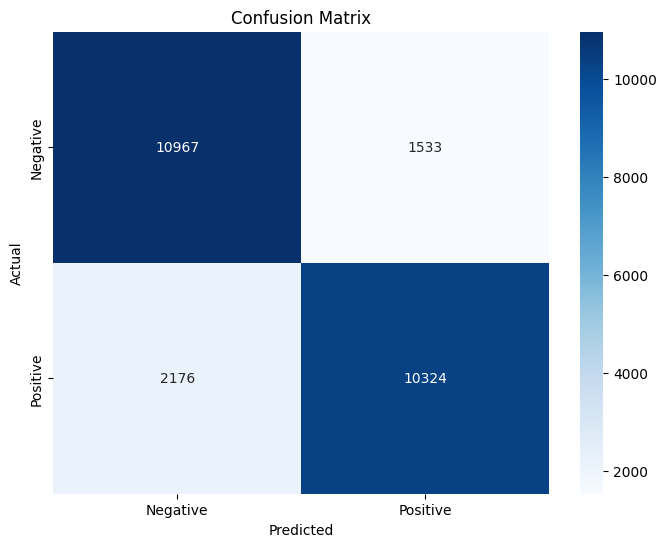

In [8]:
plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix, annot = True, cmap = 'Blues', fmt = 'd', xticklabels = ['Negative', 'Positive'], yticklabels = ['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [9]:
TN, FP, FN, TP = conf_matrix.ravel()
accuracy_cm = (TN + TP) / (TN + TP + FN + FP)
precision_cm = TP / (TP + FP)
recall_cm = TP / (TP + FN)
f1_score_cm = 2 * (precision_cm * recall_cm) / (precision_cm + recall_cm)
print(f"Accuracy: {accuracy_cm:.4f}")
print(f"Precision: {precision_cm:.4f}")
print(f"Recall: {recall_cm:.4f}")
print(f"F1 Score: {f1_score_cm:.4f}")

Accuracy: 0.8516
Precision: 0.8707
Recall: 0.8259
F1 Score: 0.8477


In [10]:
model.save('sentiment_rnn_model.h5')

In [11]:
word_index = imdb.get_word_index()
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.word_index = word_index
with open('tokenizer.pickle','wb') as handle:
    pickle.dump(tokenizer,handle)

print("Model and tokenizer saved successfully!")

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Model and tokenizer saved successfully!


In [12]:
def perform_sentiment_analysis(graph,model_path,tokenizer_path,max_length):
    """
    Perform sentiment analysis on a network graph
    using a pre-trained RNN model.
    Parameters:
    - graph (nx.Graph): NetworkX graph with 'text'
    attributes on nodes.
    - model_path (str): Path to the pre-trained RN
    N model file (e.g., 'sentiment_rnn_model.h5')
    - tokenizer_path (str): Path to the saved toke
    nizer file (e.g., 'tokenizer.pickle').
    - max_length (int): Maximum sequence length fo
    r padding (must match the model's training).
    Returns:
    - nx.Graph: The input graph with 'sentiment' a
    ttributes added to nodes.
    """
    texts = [data['text'] for _,data in graph.nodes(data=True)]
    if not texts:
        raise ValueError("Graph is empty or 'text' attribute is missing.")
    
    with open(tokenizer_path,'rb') as handle:
        tokenizer = pickle.load(handle)
    
    
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences,maxlen=max_length)
    model = load_model(model_path)
    
    predictions = model.predict(padded_sequences)
    sentiments = ['positive' if p > 0.5 else 'negative' for p in predictions.flatten()]

    for node, sentiment in zip(graph.nodes(), sentiments):
        graph.nodes[node]['sentiment'] = sentiment

    return graph

In [13]:
if __name__ == "__main__":
    # Create a sample graph
    G = nx.Graph()
    G.add_node(1, text="This is terrible.")
    G.add_node(2, text="It's absolutely amazing.")
    # Specify paths and parameters (replace with actual paths)
    model_path = 'sentiment_rnn_model.h5'
    tokenizer_path = 'tokenizer.pickle'
    max_length = 100 # Must match the model's training configuration
    try:
    # Perform sentiment analysis
        G = perform_sentiment_analysis(G, model_path, tokenizer_path, max_length)
    except ValueError as e:
        print(f"Error: {e}")
    
    # Visualize the sentiment analysis results
    pos_count = sum([1 for _, data in G.nodes(data=True) if data['sentiment'] == 'positive'])
    neg_count = sum([1 for _, data in G.nodes(data=True) if data['sentiment'] == 'negative'])
    total_count = len(G.nodes())

    pos_percent = (pos_count / total_count) * 100
    neg_percent = (neg_count / total_count) * 100

    print(f"Positive Sentiment: {pos_percent:.2f}%")
    print(f"Negative Sentiment: {neg_percent:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Positive Sentiment: 0.00%
Negative Sentiment: 100.00%
